# Practical 4

In [4]:
import numpy as np
import cvxopt
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
import os, sys

## Task 0: The Data

We will work with the data from practical 3. Load the data and split it into a training and test set. You can re-use the data splitting function from Practical 2.

In [5]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # ---------------- INSERT CODE ----------------------

    idx = np.arange(X.shape[0])
    idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

    test_idx = idx_shuffled[:int(X.shape[0]*frac)]
    train_idx = idx_shuffled[int(X.shape[0]*frac):X.shape[0]]

    X_test = X[test_idx]
    y_test = y[test_idx]
    print('Test set shapes (X and y)', X_test.shape, y_test.shape)

    X_train = X[train_idx]
    y_train = y[train_idx]
    print('Training set shapes (X and y):', X_train.shape, y_train.shape)

    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test

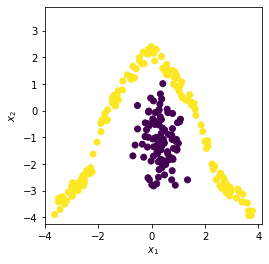

In [6]:
# load data
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:,:2], np.load('nonlin_2d_data.npy')[:, 2]
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=t_2d)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square');

In [7]:
# split data
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed=1)

Test set shapes (X and y) (75, 2) (75,)
Training set shapes (X and y): (175, 2) (175,)


## Task 1: Support Vector Machines

First, you will implement a training algorithm for the Support Vector Machine (SVM). For solving the quadratic program, we provide a simple interface to the cvxopt library below.

In SVMs, each data sample $x_n$ has a corresponding lagrange multiplier $\alpha_n$ which indicates if $x_n$ is a support vector. In the latter case $\alpha_n > 0$ holds. 
The goal of learning the SVM is to figure out which samples are support vectors by learning $\mathbf{\alpha}$. The dual SVM optimizes the following quadratic program.

$$ \min \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N \alpha_n \alpha_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m) - \sum_{n=1}^N \alpha_n$$

$$\min \frac{1}{2} ((\alpha^T t) \cdot (\alpha^T t))\cdot k(\mathbf{X}, \mathbf{X}) - \mathbf{1}^T\alpha$$
$$\min \frac{1}{2} ((\alpha^T t)^T (\alpha^T t))^T k(\mathbf{X}, \mathbf{X}) - \mathbf{1}^T\alpha$$
$$\min \frac{1}{2} \alpha^T t \alpha t^T k(\mathbf{X}, \mathbf{X}) - \mathbf{1}^T\alpha$$
subject to 
$$ 0 \leq \alpha_n \leq C $$
$$ \sum_{n=1}^N \alpha_n t_n = 0 $$ 

The quadratic program solver expects the following form:
$$ \min \frac{1}{2} \alpha^T P \alpha + \mathbf q^T \mathbf \alpha $$
subject to 

$$A \alpha = b$$
$$G \alpha \leq h $$

Here, $A$ and $G$ are matrices with one row per individual constraint. Similarly, $b$ and $h$ are vectors with one element per individual constraint.

Having trained the SVM, a prediction for an input $\mathbf{x}$ is made by:

$$ y = sign([\sum_n^{N} \alpha_n t_n k(\mathbf{x}, \mathbf{x}_n)] + b)  $$


### Task 1.1
 
Use the code provided below as a basis to express the constrained optimization problem in terms of $P, q, A, b, G$ and $h$ and implement a function `fit_svm` which passes these variables to the provided QP solver. Fit a SVM on the training data and extract its parameters.

**Hints:**
  - The box constraint $0 \leq \alpha_n \leq C$ defines two constraints of the form $G \alpha_n \leq h$ for each $\alpha_n$.
  - The inequality $x \geq 0$ is equivalent to $-x \leq 0$.

$$\alpha_i \geq 0$$
$$t^T\alpha=0$$
  => $$ P = \mathbf{t} \mathbf{t}^T k(\mathbf{X}, \mathbf{X})$$
$$q=-\mathbf{1}_N $$
$$G=-\mathbf{1}_{2N\times N}$$
$$h=\mathbf{0}_{2N} $$
$$A=\mathbf{t}^T $$
$$b=0 $$

In [8]:
def rbf_kernel(x_n, x_m, gamma=5):
    sigma = 3
    return np.exp(-gamma*np.linalg.norm(x_n-x_m, 2)**2/(sigma**2))

In [9]:
def fit_svm(X, t, kernel, C=1.0):
    '''Fit SVM using data (X,t), specified kernel and parameter C.'''

    t = np.array([-1 if l == 0 else 1 for l in t])
    n_samples, n_features = X.shape
    t = t.reshape(-1,1) * 1.

    P = np.dot(t, t.T) * kernel(X,X)
    q = np.ones(n_samples) * -1
    A = t.T
    b = np.diag(np.zeros(1))
    G = np.vstack((np.eye(n_samples) * -1, np.eye(n_samples)))
    h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * C))
    #print(G)

    assert P.shape == (len(X), len(X))
    assert len(q) == len(X)
    assert A.shape == (1, n_samples) and A.dtype == 'float'
    assert b.shape == (1, 1)
    assert len(G) == 2 * len(X)
    assert len(h) == 2 * len(X)

    return solve_quadratic_program(P, q, A, b, G, h)

def solve_quadratic_program(P, q, A, b, G, h):
    '''Uses cvxopt to solve the quadratic program.'''
    P, q, A, b, G, h = [cvxopt.matrix(var) for var in [P, q, A, b, G, h]]
    minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
    lagr_mult = np.ravel(minimization['x'])
    return lagr_mult


def extract_parameters(X, t, kernel, lagr_mult, threshold=1e-7):
    '''Computes the intercept from the support vector constraints.
    
    Inputs
        X:         predictors
        t:         targets
        kernel:    a kernel to be used
        lagr_mult: the Lagrange multipliers obtained by solving the dual QP
        threshold: threshold for choosing support vectors
    
    Returns
        lagr_mult: lagrange multipliers for the support vectors
        svs:       set of support vectors
        sv_labels: targets t_n for the support vectors
        intercept: computed intercept
    '''
    t = np.array([-1 if l == 0 else 1 for l in t])
    
    # ---------------- INSERT CODE ----------------------
    #w parameter in vectorized form
    w = ((t * lagr_mult).T @ X).reshape(-1,1)

    #Selecting the set of indices S corresponding to non zero parameters
    S = (lagr_mult > 1e-4).flatten()
    svs = X[S]
    sv_labels = t[S]
    lagr_mult = lagr_mult[S]

    #Computing intercept
    #intercept = sv_labels - np.dot(X[S], w)
    intercept = sv_labels - np.sum(lagr_mult * sv_labels * kernel(svs, svs), axis=0)
    intercept = np.sum(intercept) / intercept.size


    # ---------------- END CODE -------------------------

    return lagr_mult, svs, sv_labels, intercept


In [10]:
# Fit SVM on training data
lagr_mult = fit_svm(X_train, t_train, rbf_kernel)

# Extract parameters
lagr_mult, svs, sv_labels, intercept = extract_parameters(X_train, t_train, rbf_kernel, lagr_mult)

     pcost       dcost       gap    pres   dres
 0: -1.6800e+02 -3.7800e+02  9e+02  2e+00  2e-15
 1: -1.2889e+02 -2.5208e+02  1e+02  3e-15  2e-15
 2: -1.3989e+02 -1.4859e+02  9e+00  3e-15  3e-15
 3: -1.4000e+02 -1.4009e+02  9e-02  2e-16  6e-15
 4: -1.4000e+02 -1.4000e+02  9e-04  4e-15  5e-15
 5: -1.4000e+02 -1.4000e+02  9e-06  8e-16  5e-15
Optimal solution found.


### Task 1.2

Having learnt an SVM, we can use the calculated parameters to make predictions on novel samples.
- Implement a function `svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept)`.
- Use this function with your Gaussian RBF kernel (Practical 3) and compute the test accuracy on the 2d dataset.

In [11]:
def svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept):
    
    # ---------------- INSERT CODE ----------------------
    n_samples, n_features = X.shape
    
    y_pred = []
    for x_m in X:
        y_sum = 0
        for x_n, an, tn in zip(svs, lagr_mult, sv_labels):
            y_sum = y_sum + an*tn*kernel(x_m, x_n)
        y_pred.append(y_sum)
    return np.array(y_pred)

    prediction = np.sign(y_pred + intercept)

    # ---------------- END CODE -------------------------
    
    return prediction

In [17]:
# Calculate test accuracy
y_pred_rbf = svm_predict(X_test, rbf_kernel, lagr_mult, svs, sv_labels, intercept)
print(y_pred_rbf)

[-24.93544567   4.15426611  14.27906876   9.7811158   -7.30808881
  11.32643706 -35.68957089  -5.21056188  10.26375443 -40.87520493
   6.74850841  15.01839649  10.34928434   2.73729915   7.06521618
 -35.80332807  11.30778122 -45.48214908 -37.75316897 -15.40924172
   5.97454781 -44.13755993 -32.45222198   9.43308329  11.6798395
   7.67115885   8.80338053  10.74590544 -18.33592705   5.25705637
  -3.98665958 -45.11839639 -34.47801843  11.61465068  12.90811455
   6.32701537 -38.406782   -11.44487665 -38.74433849   8.80495321
   1.13279401 -28.09774992 -23.40515736  -4.96207847 -45.52636226
  -0.59979776 -22.716489   -14.15460778 -33.70899281 -33.93261717
   4.46160675 -32.30305627  10.86224126  11.27804243   6.54005088
  -5.22112135   9.83542654 -35.36677342 -45.3087303   15.04409689
   7.04318478  14.88818433  10.9772092   11.29939924 -36.95690632
   9.10667421 -35.89562737   2.4091163   10.02443919 -25.33055822
 -38.63211682   9.9095273   10.26110697   7.28128361  14.80964908]


### Task 1.3

- Instead of using the Gaussian RBF kernel, use the linear kernel (dot product) defined in Practical 3.
- Compare results on with both kernels with sklearn implementation (SVC)
- Visualize the predictions on the test set, the learned support vectors and the decision boundary for both kernels.

In [13]:
def linear_kernel(x,y):
    return np.matmul(x, y.T)

In [14]:
# Fit SVM with linear kernel and calculate the test accuracy
lagr_mult_linear = fit_svm(X_train, t_train, linear_kernel)
lagr_mult_linear, svs_linear, sv_labels_linear, intercept_linear = extract_parameters(X_train, t_train, linear_kernel, lagr_mult_linear)
y_pred_linear = svm_predict(X_test, linear_kernel, lagr_mult_linear, svs_linear, sv_labels_linear, intercept_linear)

print('Linear Kernel')
print('intercept = ', intercept_linear)
print('support vectors = ', svs_linear)
print(' ')
print('RBF Kernel')
print('intercept = ', intercept)
print('support vectors = ', svs)

     pcost       dcost       gap    pres   dres
 0: -1.6799e+02 -3.7889e+02  9e+02  2e+00  2e-14
 1: -1.2879e+02 -2.5279e+02  1e+02  8e-15  1e-14
 2: -1.3986e+02 -1.4886e+02  9e+00  3e-15  1e-14
 3: -1.4000e+02 -1.4009e+02  9e-02  5e-15  1e-14
 4: -1.4000e+02 -1.4000e+02  9e-04  9e-15  1e-14
 5: -1.4000e+02 -1.4000e+02  9e-06  3e-15  1e-14
Optimal solution found.
Linear Kernel
intercept =  0.20000000081979905
support vectors =  [[ 0.59407705 -1.53525138]
 [ 0.68993859 -1.74196482]
 [-1.24021561  0.39912158]
 [-1.35830716  0.25523803]
 [-1.29268128  0.59042539]
 [ 0.20321379 -1.59050242]
 [ 0.11260372 -1.03535961]
 [ 2.40976238 -2.58978338]
 [ 0.75042486 -0.92489127]
 [ 0.37033409 -1.33782804]
 [-1.86026816 -0.34956858]
 [ 0.18026019 -0.99750759]
 [ 1.15879345  0.47524048]
 [ 0.78218185 -1.79040658]
 [-0.35117143 -1.25624013]
 [ 2.62227469 -2.90531299]
 [-0.45687975  1.98398348]
 [ 0.13314422 -0.07020003]
 [ 0.41513778  1.58290782]
 [ 0.30589182 -1.3029349 ]
 [ 0.20124366 -1.53548043]
 

In [15]:
# Fit SVM using sklearn and calculate the test accuracy
clf_linear = SVC(kernel='linear')
clf_rbf = SVC(kernel='rbf')

clf_linear.fit(X_train, t_train)
clf_rbf.fit(X_train, t_train)

y_pred_linear_skl = clf_linear.predict(X_test)
y_pred_rbf_skl = clf_rbf.predict(X_test)

w_linear_skl = clf_linear.coef_[0]
w_rbf_skl = np.matmul(clf_rbf.dual_coef_,clf_rbf.support_vectors_)[0] # probably wrong

y_lin_split = y_pred_linear[(t_test == 0)], y_pred_linear[(t_test == 1)]
y_rbf_split = y_pred_rbf[(t_test == 0)], y_pred_rbf[(t_test == 1)]
y_lin_split_skl = y_pred_linear_skl[(t_test == 0)], y_pred_linear_skl[(t_test == 1)]
y_rbf_split_skl = y_pred_rbf_skl[(t_test == 0)], y_pred_rbf_skl[(t_test == 1)]
print('Linear kernel')
print('intercept = ', clf_linear.intercept_)
print('Indices of support vectors = ', clf_linear.support_)
print('Support vectors = ', clf_linear.support_vectors_)
print('Number of support vectors for each class = ', clf_linear.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf_linear.dual_coef_))
print(' ')
print('RBF kernel')
print('intercept = ', clf_rbf.intercept_)
print('Indices of support vectors = ', clf_rbf.support_)
print('Support vectors = ', clf_rbf.support_vectors_)
print('Number of support vectors for each class = ', clf_rbf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf_rbf.dual_coef_))

Linear kernel
intercept =  [0.99996738]
Indices of support vectors =  [  0   1   5   6   8   9  11  13  14  17  19  20  21  24  26  27  31  33
  38  39  43  45  53  57  60  63  68  72  74  77  79  81  82  83  85  88
  90  93  99 101 109 110 111 114 115 116 117 118 119 120 122 127 133 135
 137 138 139 140 141 142 145 146 149 150 158 160 162 167 171 174   2   3
   4   7  10  12  15  18  22  28  29  32  34  35  37  40  41  42  44  46
  47  48  49  50  51  52  54  59  61  64  66  67  71  75  76  78  80  86
  87  89  94  95  98 102 104 105 106 107 113 121 123 124 125 126 129 131
 134 136 143 144 147 148 152 153 154 157 159 163 165 166 168 169 170 172
 173]
Support vectors =  [[ 0.59407705 -1.53525138]
 [ 0.68993859 -1.74196482]
 [ 0.20321379 -1.59050242]
 [ 0.11260372 -1.03535961]
 [ 0.75042486 -0.92489127]
 [ 0.37033409 -1.33782804]
 [ 0.18026019 -0.99750759]
 [ 0.78218185 -1.79040658]
 [-0.35117143 -1.25624013]
 [ 0.13314422 -0.07020003]
 [ 0.30589182 -1.3029349 ]
 [ 0.20124366 -1.5354804

In [16]:
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
fig.suptitle('Without sklearn')
ax[0].set_title('Test data projection for linear kernel')
ax[0].hist(y_lin_split[0],label='class 0',alpha=0.5)
ax[0].hist(y_lin_split[1],label='class 1',alpha=0.5)
ax[1].set_title('Test data projection for rbf kernel')
ax[1].hist(y_rbf_split[0],label='class 0',alpha=0.5)
ax[1].hist(y_rbf_split[1],label='class 1',alpha=0.5)


fig1, ax = plt.subplots(1, 2, figsize=(9, 3))
fig1.suptitle('With sklearn')
ax[0].set_title('Test data projection for linear kernel')
ax[0].hist(clf_linear.decision_function(X_test)[t_test==np.unique(t_test)[0]],label='Class 0',alpha=0.5)
ax[0].hist(clf_linear.decision_function(X_test)[t_test==np.unique(t_test)[1]],label='Class 0',alpha=0.5)
ax[1].set_title('Test data projection for rbf kernel')
ax[1].hist(clf_rbf.decision_function(X_test)[t_test==np.unique(t_test)[0]],label='Class 0',alpha=0.5)
ax[1].hist(clf_rbf.decision_function(X_test)[t_test==np.unique(t_test)[1]],label='Class 0',alpha=0.5)
print('SVC with sklearn')
print('Linear Kernel: ', accuracy_score(t_test, y_pred_linear_skl))
print('RBF Kernel: ', accuracy_score(t_test, y_pred_rbf_skl))
plt.show()



ModuleNotFoundError: No module named 'mlxtend'

-9.455853211548515e-09 9.455853211548515e-09 -5.200315486872695e-17
-45.30731889525821 15.154752988091358 -0.6498750534150118


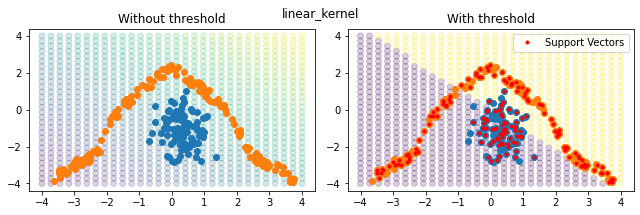

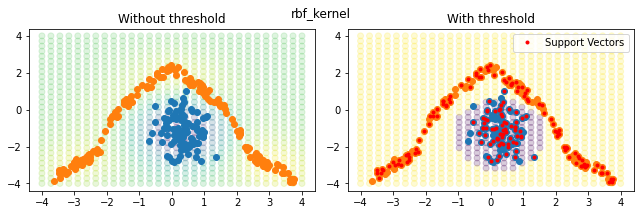

In [ ]:
# Visualize decision boundaries
def plot_decision_boundary(predict_fn, alpha, kernel, sv, sv_label, intercept, threshold):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle(kernel.__name__)
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn(np.array([grid_x, grid_y]).T, kernel, alpha, sv, sv_label, intercept)])
    ax[0].scatter(grid_x, grid_y, c=grid_t, alpha=0.2)
    X_split = X_2d[(t_2d == 0)], X_2d[(t_2d == 1)]
    ax[0].scatter(X_split[0][:,0],X_split[0][:,1])
    ax[0].scatter(X_split[1][:,0],X_split[1][:,1])
    ax[0].set_title('Without threshold')
    grid_t_copy = grid_t.copy()
    grid_t_copy[grid_t>-threshold] = 100
    grid_t_copy[grid_t<-threshold] = -100
    print(np.amin(grid_t),np.amax(grid_t),np.mean(grid_t))
    ax[1].scatter(grid_x, grid_y, c=grid_t_copy, alpha=0.2)
    ax[1].scatter(X_split[0][:,0],X_split[0][:,1])
    ax[1].scatter(X_split[1][:,0],X_split[1][:,1])
    ax[1].set_title('With threshold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.plot(sv[:, 0], sv[:, 1], 'r.', label='Support Vectors')
    plt.legend(numpoints=1)
    

predict_fn = svm_predict
plot_decision_boundary(predict_fn, lagr_mult_linear, linear_kernel, svs_linear, sv_labels_linear, intercept_linear, 0)
plot_decision_boundary(predict_fn, lagr_mult, rbf_kernel, svs, sv_labels, intercept, 11)


1.0 1.0 1.0
0.0 1.0 0.8277777777777777


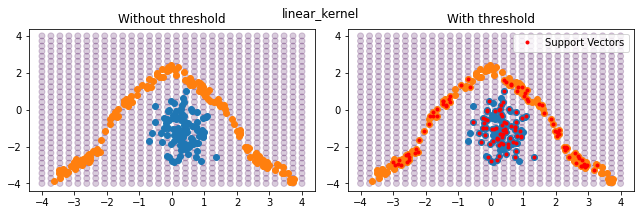

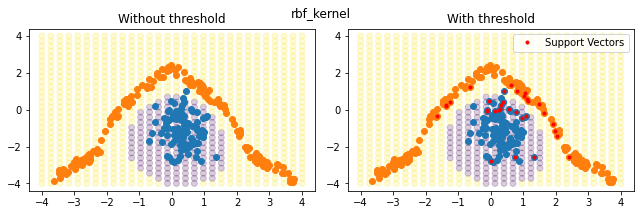

In [ ]:
# Plot decision boundary
#plot_decision_regions(X_test, t_test.astype(int), clf=clf_linear)
#plt.show()
#plot_decision_regions(X_test, t_test.astype(int), clf=clf_rbf)
#plt.show()

# Visualize decision boundaries
def plot_decision_boundary_skl(clf, kernel, threshold):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle(kernel.__name__)
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        clf.predict(np.array([grid_x, grid_y]).T)])
    ax[0].scatter(grid_x, grid_y, c=grid_t, alpha=0.2)
    X_split = X_2d[(t_2d == 0)], X_2d[(t_2d == 1)]
    ax[0].scatter(X_split[0][:,0],X_split[0][:,1])
    ax[0].scatter(X_split[1][:,0],X_split[1][:,1])
    ax[0].set_title('Without threshold')
    grid_t_copy = grid_t.copy()
    grid_t_copy[grid_t>-threshold] = 100
    grid_t_copy[grid_t<-threshold] = -100
    print(np.amin(grid_t),np.amax(grid_t),np.mean(grid_t))
    ax[1].scatter(grid_x, grid_y, c=grid_t_copy, alpha=0.2)
    ax[1].scatter(X_split[0][:,0],X_split[0][:,1])
    ax[1].scatter(X_split[1][:,0],X_split[1][:,1])
    ax[1].set_title('With threshold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.plot(clf.support_vectors_[:,0], clf.support_vectors_[:,1], 'r.', label='Support Vectors')
    plt.legend(numpoints=1)
    

predict_fn = svm_predict
plot_decision_boundary_skl(clf_linear, linear_kernel, 0)
plot_decision_boundary_skl(clf_rbf, rbf_kernel, 0)

# Task 2: Decision Trees

Next, we will implement a simple decision tree classifier using the Wine dataset, one of the standard sklearn datasets. 

We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Plot the distribution of the first feature of for each class of the wine dataset.
2. Implement a function `gini_impurity(t)` that computes the Gini impurity for an array of labels `t`.
3. Calculate the removed Gini impurity for a split after 50 samples, i.e. between `t[:50]` and `t[50:]`.

In [ ]:
# Load Wine dataset and split into train+test set

X, t = load_wine(return_X_y=True)
X_train, X_test, t_train, t_test = split_data(X, t)

Test set shapes (X and y) (53, 13) (53,)
Training set shapes (X and y): (125, 13) (125,)


(39, 13)


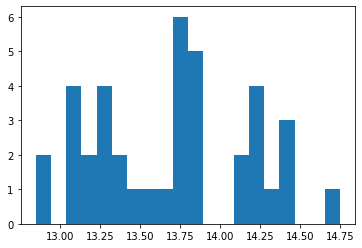

(53, 13)


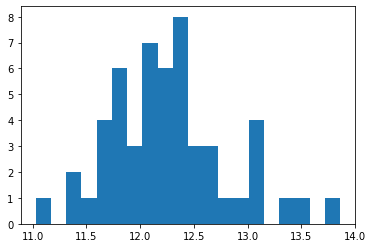

(33, 13)


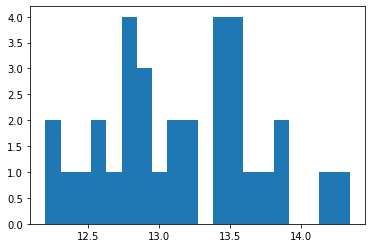

In [ ]:
# Plot distribution
for i in range(0,3):
    x=X_train[t_train==i]
    print(x.shape)
    plt.hist(x[:,0],bins=20)
    plt.show()

In [ ]:
# Compute Gini impurity
def gini_impurity(t):
    G=0
    _, u_cn = np.unique(t,return_counts=True)
    n = len(t)
    for i in u_cn:
        p = i/n
        G += p * (1-p)
    return G

t = [0,0,0,1,1,1]
print('Gini impurity = ', gini_impurity(t))

Gini impurity =  0.5


### Task 2.2
Split the data along the first 12 features and plot the removed Gini impurity at different values of this feature. Which is the optimal split?

0


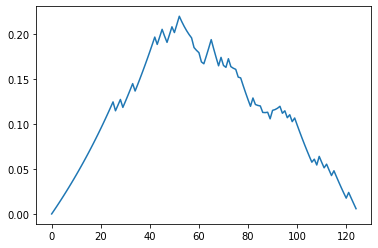

1


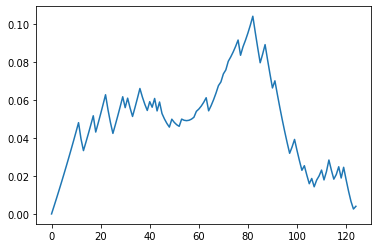

2


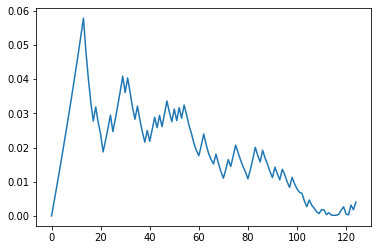

3


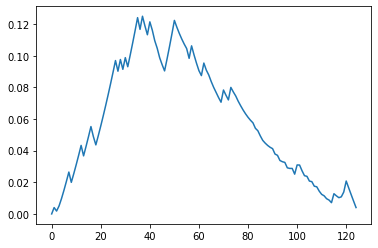

4


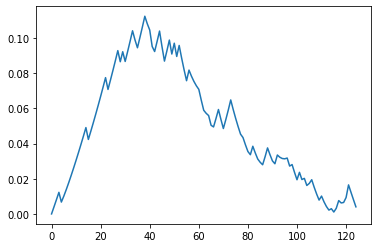

5


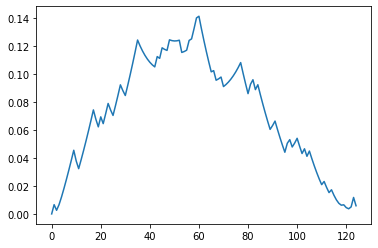

6


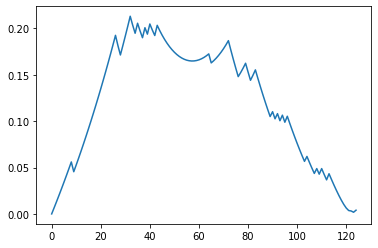

7


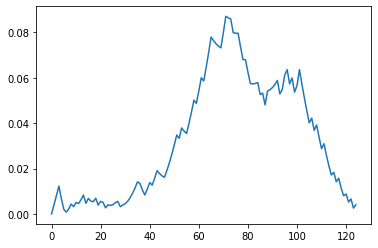

8


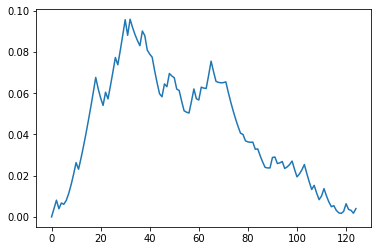

9


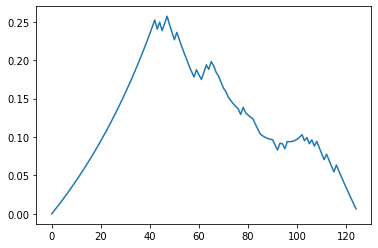

10


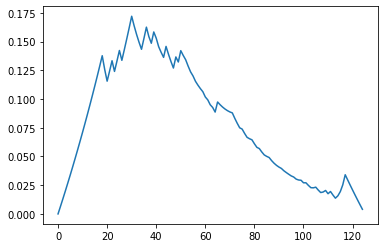

11


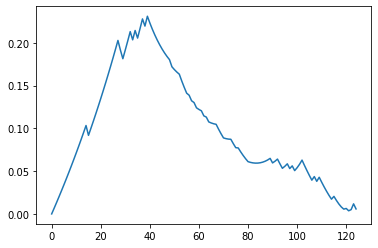

12


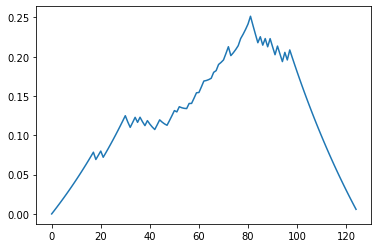

In [ ]:
# Plotting
for h in range(0,len(X_train[0])):
    print(h)
    x = X_train[:,h]

    idx = np.argsort(x)
    x_s = x[idx]
    t_s = t_train[idx]
    G = gini_impurity(t_s)
    gi = []
    for i in range(0,len(t_s)):
        left = t_s[0:i]
        right = t_s[i:]
        gi.append(G-(((len(left)/len(x))*gini_impurity(left))+((len(right)/len(x))*gini_impurity(right))))
    plt.plot(gi)
    plt.show()

### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.
3. Switch back to the synthetic 2d dataset from the beginning (kernel methods). Compute scores and visualize the decisions in a 2d grid.

In [ ]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold


class Leaf:
    def __init__(self, label):
        self.label = label


In [ ]:
# Implement recursive tree function

def build_tree(X, t, depth, max_depth=3, n_labels=2):
    
    # ---------------- INSERT CODE ----------------------
    if len(t)==1:
        return Leaf(t)
    
    G = gini_impurity(t)
    max_gain = 0
    max_dim = -1
    max_threshold = -1
    for d in range(len(X[0])):
        x = X[:,d]
        idx = np.argsort(x)
        x_s = x[idx]
        t_s = t[idx]
        gg = 0
        threshold = -1
        for i in range(0,len(t_s)):
            left = t_s[0:i]
            right = t_s[i:]
            g_new = G-(((len(left)/len(x))*gini_impurity(left))+((len(right)/len(x))*gini_impurity(right)))
            #print(g_new)
            if g_new > gg: 
                #print(g_new, i)
                gg = g_new
                threshold = x_s[i] 
                
        if gg > max_gain:
            
            max_gain = gg
            max_dim = d
            max_threshold = threshold
  
    Xl = X[X[:,max_dim]<max_threshold,:]
    tl = t[X[:,max_dim]<max_threshold]
    Xr = X[X[:,max_dim]>=max_threshold,:]
    tr = t[X[:,max_dim]>=max_threshold]
    depth+=1
    if depth<max_depth and max_dim != -1:
        left_child = build_tree(Xl,tl,depth,max_depth,n_labels)
        right_child = build_tree(Xr,tr,depth,max_depth,n_labels)
    else:
        # print('Leaf(np.unique(t)',np.unique(t))
        u, c = np.unique(t, return_counts=True)
        return Leaf(u[np.argmax(c)])
    return Node(left_child, right_child, max_dim, max_threshold)

    # ---------------- END CODE -------------------------

    
def predict_tree(node, x):
    if isinstance(node, Leaf):
        return node.label
    # ---------------- INSERT CODE ----------------------
    if x[node.n_feat] < node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)


    # ---------------- END CODE -------------------------

In [ ]:
# Build tree
treex = build_tree(X_train, t_train, 0, max_depth=3, n_labels=3)

In [ ]:
# Calculate training and test scores
a=0
for i in range(len(X_test)):
    if predict_tree(treex, X_test[i])==t_test[i]:
        a += 1
print('Test score')
print(a,len(X_test))
print(a/(len(X_test)))

b=0
for i in range(len(X_train)):
    if predict_tree(treex, X_train[i])==t_train[i]:
        b += 1
print('Training score')
print(b,len(X_train))
print(b/(len(X_train)))

Test score
47 53
0.8867924528301887
Training score
115 125
0.92


Test score
51 53
0.9622641509433962


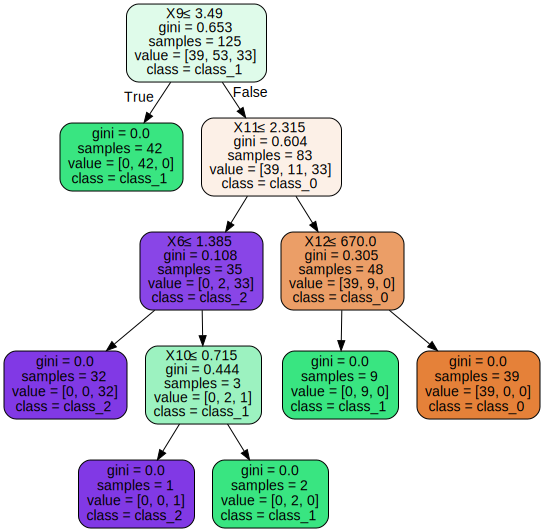

In [ ]:
# Calculate test score using sklearn
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, t_train)
a=0
for i in range(len(X_test)):
    if clf.predict(X_test[i].reshape(1, -1)) == t_test[i]:
        a += 1
print('Test score')
print(a,len(X_test))
print(a/(len(X_test)))
import graphviz 
data = load_wine()
dot_data = tree.export_graphviz(clf, out_file=None, 
                                class_names=data.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 
graph

In [ ]:
# Calculate test score for synthetic 2D dataset
X_2d, t_2d = np.load('data/nonlin_2d_data.npy')[:,:2], np.load('data/nonlin_2d_data.npy')[:, 2]
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed=1)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, t_train)

score = clf.score(X_test, t_test) 
print(score)

Test set shapes (X and y) (75, 2) (75,)
Training set shapes (X and y): (175, 2) (175,)
0.96


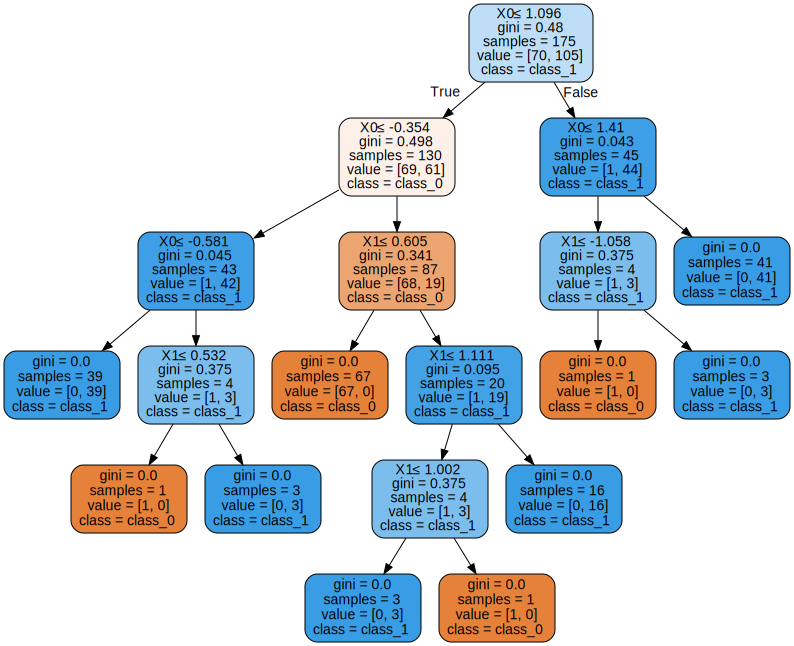

In [ ]:
# Visualize 
data = load_wine()
dot_data = tree.export_graphviz(clf, out_file=None, 
                                class_names=data.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 
graph